In [5]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [6]:
%presentation_style

In [7]:
%%capture

%set_random_seed 12

In [8]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    Introduction to Simulation-Based Inference
</div>
<div class="md-slide title">
    
</div>
<div class="md-slide title">
    Bayesian Inference for Simulation-Based Models
</div>

# Simulators are abundant in science and engineering

<img src="_static/images/simulator_scales.png" alt="Snow" style="width:100%;">

TODO: Add engineering / industry example figure



# What are simulation-based models?
- explicit models, e.g., ODEs, PDEs: "simulator as numerical solver"
 
- implicit models: "simulator as black-box computer simulation"

- anything in-between: input parameter $\theta$ output simulated data $x$

\begin{equation}
    x = simulator(\theta)
\end{equation}


# Example: Simulating pandemics with the SIR model

- Models epidemiological dynamics -> used during covid-19
- Three states: **S**usceptible **I**nfected **R**ecovered

<img src="_static/images/sir_grey.png" alt="Snow" style="width:30%;">

Dehning et al., Science, 2020

# Example: Simulating the covid pandemic with the SIR model

<img src="_static/images/covid_modelling_example.png" alt="Snow" style="width:80%;">

tagesschau.de; Dehning et al., Science, 2020

# Scientific discovery with simulation-based models

<img src="_static/images/scientific_discovery_loop.png" alt="Snow" style="width:100%;">


# Example: Simulating pandemics with the SIR model

- Initial condition: $S=N-1,\; I=1,\; R=0$
- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$

\begin{equation}
N = 100000\\
\beta \sim \text{LogNormal}(\log(0.4), 0.5)\\ 
\gamma \sim \text{LogNormal}(\log(1/8), 0.2) \\[5mm]
\frac{dS}{dt} = -\beta \frac{SI}{N} \\ 
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I\\ 
\frac{dR}{dt} = \gamma I
\end{equation}

# Central challenge: find parameters $\theta$ that reproduce data $x$

- search single-best fitting parameters (hand-tuning, grid-search, optimization)? 
    - does not scale to high-dimensional problems
    - what about uncertainty in data (aleatoric) and parameter estimates (epistemic)? 
    - what if there are multiple solutions? 
- ...? 

<img src="_static/images/drake_pro_bayesian_inference.jpeg" alt="Snow" style="width:50%;">

# Central challenge: find parameters $\theta$ that reproduce data $x$

## ~~search single best-fitting parameters~~
    
## Bayesian inference
<img src="_static/images/bayesian_inference.png" alt="Snow" style="width:90%;">

# Bayesian inference for simulation-based models

### Difficult because likelihood usually not accessible

- ODEs / black-box simulators do not have analytical expression for the likelihood $p(x | \theta)$
- **MCMC** or **variational inference** cannot be applied! 

\begin{equation}
p(\theta |x) = \frac{p(x | \theta) \; p(\theta)}{p(x)} \propto p(x | \theta) \; p(\theta)
\end{equation}

### Idea: use simulated data to circumvent lack of likelihood-access
- we cannot evaluate the likelihood, but we can simulate data! 
- "likelihood-free" inference

## Outline 
### Part 1: **Approximate Bayesian Computatin (ABC)**
### Part 2: **Simulation-Based Inference (SBI)**


# Approximate Bayesian Computation (ABC)

## rejection sampling

<img src="_static/images/ABC_concept_figure.png" alt="Snow" style="width:100%;">

Diggle et al. (1984), Beaumont et al. (2002), Figure from Boelts (2023)

## Approximate Bayesian Computation (ABC)

<img src="_static/images/ABC_algorithm.png" alt="Snow" style="width:100%;">

# Questions?

# Exercise 1: Implement rejection ABC for the SIR model

<img src="_static/images/sir_grey.png" alt="Snow" style="width:40%;">

- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$
- Initial condition: $N=100000, \; S=N-1,\; I=1,\; R=0$

\begin{equation}
\frac{dS}{dt} = -\beta \frac{SI}{N} \\ 
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I\\ 
\frac{dR}{dt} = \gamma I
\end{equation}


# Exercise 1: Implement rejection ABC for the SIR model

- **Task**: 
    - we collected some PCR test results $x_o$
    - use the rejection ABC algorithm to infer the underlying rate $\beta$ and $\gamma$

- **Setup**
    - prior and simulator are given:
    - $x = $ "10 evenly spaced samples in time from the infectious group $I$."
    
\begin{equation}
\theta_i \sim p(\theta) = p(\beta)p(\gamma) \\[3mm]
x_i | \theta_i \sim \text{SIR}(\beta_i, \gamma_i)
\end{equation}

In [9]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch

from torch import Tensor, log, ones, zeros

# load pre-simulated SIR data.
with open("../data/sir_simulation_data.pkl", "rb") as fh:
    sir_theta, sir_x = pickle.load(fh).values()

# TODO: pseudo simulator by drawing from pre-simulated data.
def sample_and_simulate(num_samples=1):
    time.sleep(0.0001) 
    idx = torch.randint(low=0, high=sir_theta.shape[0], size=(num_samples,))
    return sir_theta[idx], sir_x[idx]

# Simulate observed data (we take the last pre-simulated data point that is excluded above.)
true_theta = sir_theta[-1]
x_o = sir_x[-1]

## TODO

1. implement a distance function
2. implement the rejection ABC algorithm
3. select an epsilon to obtain about 100 posterior samples

### Part 1: Implement a distance function

In [10]:
def distance(x: Tensor, x_o: Tensor) -> Tensor: 
    """Returns the mean squared error between x and x_o.
    
    Note: the mean is taken over x, i.e., over the second dimension.
    
    Args: 
        x: Tensor of simulated data, (batch, dim_x)
        x_o: Tensor of observed data, (1, dim_x)
        
    Returns: 
        distance: Tensor of MSEs, (batch, 1)
    """
    # Your code goes here...

In [11]:
# Part 1 solution.
def distance(x: Tensor, x_o: Tensor) -> Tensor: 
    """Returns the mean squared error between x and x_o.
    
    Note: the mean is taken over x, i.e., over the second dimension.
    
    Args: 
        x: Tensor of simulated data, (batch, dim_x)
        x_o: Tensor of observed data, (1, dim_x)
        
    Returns: 
        distance: Tensor of MSEs, (batch, 1)
    """
    return torch.mean((x - x_o)**2, 1)

### Part 2: Implement the rejection ABC algorithm

Implement rejection ABC: 
- A loop that repeatedly samples theta from the prior 
- simulates corresponding data x (using the sample_and_simulate function)
- and then accepts only those theta for which x is close to x_o

In [12]:
def rejection_abc(num_simulations: int, 
                  sample_and_simulate: Callable, 
                  epsilon: float, 
                  x_o: Tensor):
    """Returns a tensor of accepted posteriors samples using the rejection ABC algorithm.
    
    Args: 
        num_simulations: simulation budget
        sample_and_simulate: a function that samples a parameter from the prior and simulates the SIR model.
        epsilon: the rejection threshold for the distance between x and x_o.abs
        x_o: the observed data.
    Returns:
        posterior_samples: the accepted theta, i.e., theta for which d(x, x_o) < epsilon.
        theta: all sampled parameters (optional)
        x: all simulated data (optional)
    """
    
    posterior_samples = []
    theta = []
    x = []
    
    # Your code goes here...

In [13]:
# Part 2 solution.
def rejection_abc(num_simulations: int, 
                  sample_and_simulate: Callable, 
                  epsilon: float, 
                  x_o: Tensor):
    """Returns a tensor of accepted posteriors samples using the rejection ABC algorithm.
    
    Args: 
        num_simulations: simulation budget
        sample_and_simulate: a function that samples a parameter from the prior and simulates the SIR model.
        epsilon: the rejection threshold for the distance between x and x_o.abs
        x_o: the observed data.
    Returns:
        posterior_samples: the accepted theta, i.e., theta for which d(x, x_o) < epsilon.
        theta: all sampled parameters (optional)
        x: all simulated data (optional)
    """
    
    posterior_samples = []
    theta = []
    x = []
    
    for idx in range(num_simulations):
        
        theta_i, x_i = sample_and_simulate()
        theta.append(theta_i)
        x.append(x_i)
        
        if distance(x_i, x_o) < epsilon:
            posterior_samples.append(theta_i)
        
    print(f"Rejection ABC: {len(posterior_samples)} accepted samples.")
        
    return torch.cat(posterior_samples), torch.cat(theta), torch.cat(x)

### Part 3: Obtain about 100 posterior samples

Choose an epsilon and run the rejection ABC algorithm such that obtain about 100 posterior samples.

In [14]:
# Your code goes here...

# eps = ?
# num_simulations = ?
# posterior_samples, theta, x = rejection_abc(...)

In [15]:
# Part 3 solution.
eps = 200
num_simulations = 50000
posterior_samples, theta, x = rejection_abc(num_simulations, sample_and_simulate, eps, x_o)


Rejection ABC: 203 accepted samples.


## Plotting

Plot prior and posterior samples, and "true" underlying theta.

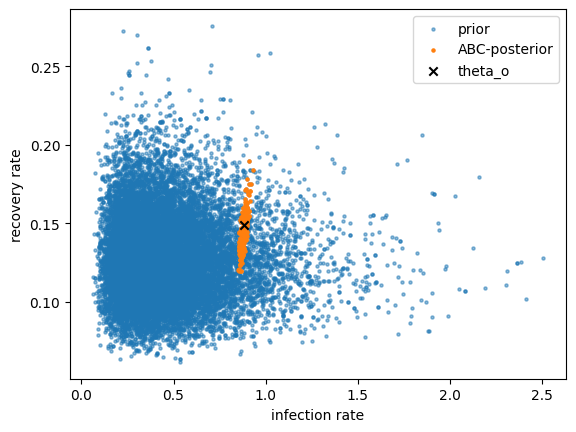

In [16]:
# Select number of samples for scatter plot.
num_prior_samples = 20000
plt.scatter(theta[:num_prior_samples, 0], theta[:num_prior_samples, 1], s=5, alpha=0.5, label="prior")
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], s=5, label="ABC-posterior")
plt.scatter(*true_theta, marker="x", color="k", label="theta_o")
plt.xlabel("infection rate")
plt.ylabel("recovery rate")
plt.legend();

# Summary

## Simulation-based inference (SBI)
- use Bayesian inference to identify parameters of simulation-based models
- Likelihood is not accessible -> use data simulated from the model instead

## Part 1: "Classical SBI" aka Approximate Bayesian Computation (ABC) 

<img src="_static/images/ABC_concept_figure.png" alt="Snow" style="width:100%;">

### Advantage
- conceptually simple: fast to implement

### Disadvantages
- curse of dimensionality: what if $\theta$ or $x$ is high-dimensional? 

## Part 2: ML-powered simulation-based inference

Replace rejection sampling with **neural density estimation**.

<img src="_static/images/sbi_concept_figure.png" alt="Snow" style="width:100%;">

Papamakarios et al. 2016; Cranmer et al. 2020, Figure from Boelts (2023)

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>